In [1]:
import os
import re
import glob
import pysam
import networkx as nx
import pandas as pd
import numpy as np
from itertools import combinations
from subprocess import check_output
import xarray as xr
from pybedtools import BedTool
from collections import defaultdict, Counter
import dask
from ALLCools.plot import *
from ALLCools.mcds import MCDS, RegionDS
from ALLCools.dmr import call_dms, call_dmr
import pathlib
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from ALLCools.mcds.correlation import region_correlation, get_corr_table
from ALLCools.dmr.parse_methylpy import methylpy_to_region_ds
import seaborn as sns
from multiprocessing import Pool, Manager, Process
from functools import partial
import argparse
from pingouin import partial_corr
from ALLCools.mcds import MCDS
import cooler

In [2]:
group_name = 'L6bCT_ENT_Glut'

In [3]:
ct = group_name

## identify deg

In [4]:
deg_dir = f'/data/female-amb/Diff.Result/DEG.stats/{ct}'
expr = pd.read_hdf(f'{deg_dir}/expr.hdf').T
stats = np.load(f"{deg_dir}/{ct}.2mo-{ct}.18mo.npz") #fc:(2mo/18mo)

In [5]:
result = pd.DataFrame({'fc': (expr[f'{ct}.18mo'] /expr[f'{ct}.2mo']).values,'fdr':stats['fdr']}, index = expr.index)
result['log2(18mo/2mo)'] = np.log2(result['fc'])
result['-log10(padj)'] = -np.log10(result['fdr'])
result.head()

,fc,fdr,log2(18mo/2mo),-log10(padj)
gene,,,,
Xkr4,0.968447,0.000204,-0.046255,3.689971
Gm1992,1.862329,0.000229,0.897108,3.639327
Gm19938,1.954747,0.088458,0.966982,1.053265
Mrpl15,1.453486,1.000000,0.539517,-0.000000
Lypla1,0.850104,1.000000,-0.234289,-0.000000


In [6]:
sig_result = result[(result['fdr'] < 0.01) & (abs(result['log2(18mo/2mo)']) > 0.2)]
sig_result.shape

(1160, 4)

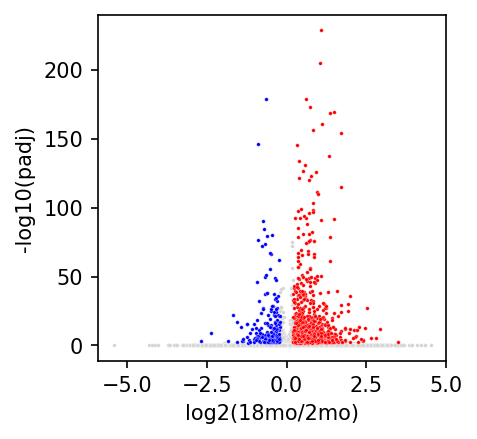

In [7]:
fig, ax = plt.subplots(figsize = (3,3), dpi = 150)
sns.scatterplot(data = result,
                ax = ax,
                color = 'lightgrey',
                s = 3,
                x = 'log2(18mo/2mo)',
                y = '-log10(padj)')

sns.scatterplot(data = sig_result[sig_result['log2(18mo/2mo)'] > 0],
                ax = ax,
                color = 'red',
                s = 3,
                x = 'log2(18mo/2mo)',
                y = '-log10(padj)')

sns.scatterplot(data = sig_result[sig_result['log2(18mo/2mo)'] < 0],
                ax = ax,
                color = 'blue',
                s = 3,
                x = 'log2(18mo/2mo)',
                y = '-log10(padj)')

for i, row in sig_result.iterrows():
    if row['-log10(padj)'] > 100 and (row['log2(18mo/2mo)'] > 3 or row['log2(18mo/2mo)'] < -3):
        ax.text(row['log2(18mo/2mo)'], row['-log10(padj)'], 
                row.name, 
                color='black', fontsize=6)

In [8]:
sig_result = result[(result['fdr'] < 0.01) & (abs(result['log2(18mo/2mo)']) > 0.2)]
sig_result.shape

(1160, 4)

## cal abc score

In [9]:
chrom_size_path = '/ref/m3C/mm10.main.nochrM.nochrY.chrom.sizes'
gene_meta_path = '/data/metadata/gencode.vM22.basic.annotation.gene.flat.tsv.gz'
dmr_zarr_path = f"{ct}.AllDMR.mcds"
cool_path = '/data/female-amb/AMB.CoolFiles/CellType.Age.Raw.5kb.mcool'
leg = [f"{ct}.{age}" for age in ['8wk','9mo','18mo']]

In [10]:
mouse_chrs = ['chr' + str(x) for x in range(1,20)] + ['chrX']
mouse_size = pd.read_csv(chrom_size_path, sep="\t", index_col=0, names=['length']).loc[mouse_chrs]

In [11]:
mouse_genes = pd.read_csv(gene_meta_path,sep="\t")[['chrom', 'start', 'end', 'gene_id','gene_name']]
mouse_genes.columns = ['chrom', 'start', 'end', 'geneID','gene_name']
mouse_genes['geneID'] = [re.sub("\.[0-9]+$", "", x) for x in mouse_genes['geneID']]
mouse_genes.index = mouse_genes['geneID']
mouse_genes = mouse_genes[~mouse_genes['chrom'].isin(['chrY', 'chrM'])]

In [12]:
#mouse_genes.to_csv('use.mouse_genes.csv')

In [13]:
var_dim = 'AllDMR'
dmr_RDS = MCDS.open(dmr_zarr_path, obs_dim='sample', var_dim=var_dim )
dmr_RDS.add_mc_frac(var_dim=var_dim,  normalize_per_cell=False)

In [14]:
dmrbed = pd.DataFrame(
            [dmr_RDS.coords[f"{var_dim}_chrom"].to_pandas(),
             dmr_RDS.coords[f"{var_dim}_start"].to_pandas(),
             dmr_RDS.coords[f"{var_dim}_end"].to_pandas(),],index=["chrom", "start", "end"],).T
dmrbed.head()

,chrom,start,end
AllDMR,,,
chr1:3003639-3003639,chr1,3003639,3003641
chr1:3040554-3040554,chr1,3040554,3040632
chr1:3066357-3066357,chr1,3066357,3066359
chr1:3069472-3069472,chr1,3069472,3069474
chr1:3089809-3089809,chr1,3089809,3089811


In [15]:
def get_gene_abc_score(group, gene_id):
    ct_age_cool = cooler.Cooler(f'{cool_path}/{group}.raw.mcool::resolutions/10000')

    max_distance = 5000000
    ABC_score = defaultdict(dict)
    total_ABC = dict()
    
    gene_coords = mouse_genes.loc[gene_id].to_dict()
    chrom = gene_coords['chrom']
    gene_start = int(gene_coords['start']) - 2000
    gene_end = int(gene_coords['end']) + 2000
    
    start = int(gene_coords['start']) - max_distance
    end = int(gene_coords['start']) + max_distance
    start = 1 if start < 0 else start
    end = mouse_size.loc[chrom, 'length'] if end > mouse_size.loc[chrom, 'length'] else end

    ct_age_dmr = dmrbed
    gene_dmr = ct_age_dmr[(ct_age_dmr['chrom'] == gene_coords['chrom']) & (ct_age_dmr['start'] > start)
                                       & (ct_age_dmr['end'] < end)]
    gene_dmr = gene_dmr[gene_dmr['end'] - gene_dmr['start']>=10]

    dmr_mCG = dmr_RDS.sel({var_dim: gene_dmr.index, 'mc_type':'CGN'})[f'{var_dim}_da_frac'].to_pandas()
    dmr_mCG = dmr_mCG.loc[leg]
    dmr_activity = 1 - dmr_mCG
    dmr_activity_dict = dmr_activity.to_dict()

    # calculate interactions of each DMR to target gene
    dmr_contacts = defaultdict(dict)
    contacts = ct_age_cool.matrix(balance=False, as_pixels=True, join=True).fetch(f'{chrom}:{start}-{end}')

    gene_contacts_upper = contacts[(contacts['start1'] >= gene_start) & (contacts['start1'] <= gene_end)]
    gene_contacts_down = contacts[(contacts['start2'] >= gene_start) & (contacts['start2'] <= gene_end)]
    gene_contacts_upper = gene_contacts_upper[(gene_contacts_upper['start2'] >= gene_start) & (gene_contacts_upper['start2'] <= end)]
    gene_contacts_down = gene_contacts_down[(gene_contacts_down['start1'] >= start) & (gene_contacts_down['start1'] <= gene_start)]

    for z, row in gene_contacts_upper.iterrows():
        z_bin_dmrs = gene_dmr[(gene_dmr['start'] >= row.start2) & (gene_dmr['end'] <= row.end2)]         
        for dmr in z_bin_dmrs.index:
            dmr_contacts[dmr] = row['count']
    
    for y, row in gene_contacts_down.iterrows():
        y_bin_dmrs = gene_dmr[(gene_dmr['start'] >= row.start1) & (gene_dmr['end'] <= row.end1)]         
        for dmr in y_bin_dmrs.index:
            dmr_contacts[dmr] = row['count']
    
    for dmr in dmr_contacts:
        total_ABC = dmr_activity_dict[dmr][group] * dmr_contacts[dmr]
    
    gene_dmr['new_index'] = gene_dmr['chrom'] + '-' + gene_dmr['start'].astype(str) + '-' + gene_dmr['end'].astype(str) 
    old_to_new_dict = gene_dmr['new_index'].to_dict()

    for dmr in dmr_contacts:
        new_dmr = old_to_new_dict[dmr]
        EG = f'{new_dmr}-{gene_id}'
        try:
            activity = dmr_activity_dict[dmr][group]
            contact = dmr_contacts[dmr]
            ABC_score[EG] = activity, contact, (activity *  contact/ total_ABC)
        except:
            ABC_score[EG][celltype] = np.nan
    ABC_score_df = pd.DataFrame.from_dict(ABC_score, orient='index')
    #ABC_score_df.columns = [group]
    return ABC_score_df

In [16]:
all_genes = mouse_genes[mouse_genes['gene_name'].isin(sig_result.index)].index
len(all_genes)

1152

In [17]:
import ray 
ray.init(ignore_reinit_error=True)

@ray.remote(num_cpus = 2)
def get_gene_abc_score(group, gene_id):
    ct_age_cool = cooler.Cooler(f'{cool_path}/{group}.raw.mcool::resolutions/10000')

    max_distance = 5000000
    ABC_score = defaultdict(dict)
    total_ABC = dict()
    
    gene_coords = mouse_genes.loc[gene_id].to_dict()
    chrom = gene_coords['chrom']
    gene_start = int(gene_coords['start']) - 2000
    gene_end = int(gene_coords['end']) + 2000
    
    start = int(gene_coords['start']) - max_distance
    end = int(gene_coords['start']) + max_distance
    start = 1 if start < 0 else start
    end = mouse_size.loc[chrom, 'length'] if end > mouse_size.loc[chrom, 'length'] else end

    ct_age_dmr = dmrbed
    gene_dmr = ct_age_dmr[(ct_age_dmr['chrom'] == gene_coords['chrom']) & (ct_age_dmr['start'] > start)
                                       & (ct_age_dmr['end'] < end)]
    gene_dmr = gene_dmr[gene_dmr['end'] - gene_dmr['start']>=10]

    dmr_mCG = dmr_RDS.sel({var_dim: gene_dmr.index, 'mc_type':'CGN'})[f'{var_dim}_da_frac'].to_pandas()
    dmr_mCG = dmr_mCG.loc[leg]
    dmr_activity = 1 - dmr_mCG
    dmr_activity_dict = dmr_activity.to_dict()

    # calculate interactions of each DMR to target gene
    dmr_contacts = defaultdict(dict)
    contacts = ct_age_cool.matrix(balance=False, as_pixels=True, join=True).fetch(f'{chrom}:{start}-{end}')

    gene_contacts_upper = contacts[(contacts['start1'] >= gene_start) & (contacts['start1'] <= gene_end)]
    gene_contacts_down = contacts[(contacts['start2'] >= gene_start) & (contacts['start2'] <= gene_end)]
    gene_contacts_upper = gene_contacts_upper[(gene_contacts_upper['start2'] >= gene_start) & (gene_contacts_upper['start2'] <= end)]
    gene_contacts_down = gene_contacts_down[(gene_contacts_down['start1'] >= start) & (gene_contacts_down['start1'] <= gene_start)]

    for z, row in gene_contacts_upper.iterrows():
        z_bin_dmrs = gene_dmr[(gene_dmr['start'] >= row.start2) & (gene_dmr['end'] <= row.end2)]         
        for dmr in z_bin_dmrs.index:
            dmr_contacts[dmr] = row['count']
    
    for y, row in gene_contacts_down.iterrows():
        y_bin_dmrs = gene_dmr[(gene_dmr['start'] >= row.start1) & (gene_dmr['end'] <= row.end1)]         
        for dmr in y_bin_dmrs.index:
            dmr_contacts[dmr] = row['count']
    
    for dmr in dmr_contacts:
        total_ABC = dmr_activity_dict[dmr][group] * dmr_contacts[dmr]
    
    gene_dmr['new_index'] = gene_dmr['chrom'] + '-' + gene_dmr['start'].astype(str) + '-' + gene_dmr['end'].astype(str) 
    old_to_new_dict = gene_dmr['new_index'].to_dict()

    for dmr in dmr_contacts:
        new_dmr = old_to_new_dict[dmr]
        EG = f'{new_dmr}-{gene_id}'
        try:
            activity = dmr_activity_dict[dmr][group]
            contact = dmr_contacts[dmr]
            ABC_score[EG] = activity, contact, (activity *  contact/ total_ABC)
        except:
            ABC_score[EG][celltype] = np.nan
    ABC_score_df = pd.DataFrame.from_dict(ABC_score, orient='index')
    #ABC_score_df.columns = [group]
    return ABC_score_df

2024-04-14 06:29:14,508	INFO worker.py:1620 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


In [18]:
for group in [leg[0],leg[2]]:
    ct, age = group.split('.')
    results = [get_gene_abc_score.remote(group, gene) for gene in all_genes]
    all_results = ray.get(results)
    all_results = pd.concat(all_results)
    all_results.to_csv(f"{group}.abc_score.csv")
    print(f"{group} done")    

2024-04-14 06:29:15,694	WARNING worker.py:2000 -- Warning: The remote function __main__.get_gene_abc_score is very large (23 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


L6bCT_ENT_Glut.8wk done
L6bCT_ENT_Glut.18mo done


In [38]:
# import ray 
# ray.init(ignore_reinit_error=True)

# @ray.remote(num_cpus = 2)
# def get_gene_abc_score_by_chunk(group, gene_list):
#     tmp = []
#     for gene_id in gene_list:
#         abc_df = get_gene_abc_score(group, gene_id)
#         tmp.append(abc_df)
#     tmp = pd.concat(tmp)
#     return tmp